In [56]:
import typing

## Rewards calculation

In [42]:
def round_to_precision(value, precision, decimal_places=4):
	rounded = round(value / precision, decimal_places)
	return rounded

def calculate_vesting(vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch, precision=1e7):
	"""
	Calculate vesting rewards for a given set of parameters. Without slashing and Deal rewards

	This function computes the total rewards earned, unlocked rewards, and rewards still in vesting
	based on the provided vesting schedule and current epoch.

	Args:
		vesting_period_count (int): The total number of vesting periods.
		vesting_period_duration (int): The duration of each vesting period in epochs.
		start_epoch_of_cc (int): The epoch when the Capacity Commitment (CC) starts.
		end_epoch_of_cc (int): The epoch when the Capacity Commitment (CC) ends.
		reward_per_epoch (float): The reward earned per epoch.
		current_epoch (int): The current epoch for which to calculate vesting.
		precision (float, optional): The precision factor for internal calculations. Defaults to 1e7.

	Returns:
		dict: A dictionary containing the following keys:
			- 'total_earned' (float): The total rewards earned up to the current epoch or CC end.
			- 'unlocked' (float): The amount of rewards that have been unlocked and are ready to withdraw.
			- 'in_vesting' (float): The amount of rewards still locked in vesting.

	Note:
		- All epoch-related inputs should be integers.
		- reward_per_epoch can be a float, it will be converted to an integer using the precision factor.
		- The function uses integer arithmetic internally to avoid floating-point precision issues.
		- Results are rounded to 4 decimal places by default.
	"""


	# CONVERT TO INTEGERS
	# All arguments are converted, just in case
	precision = int(precision)
	reward_per_epoch = int(reward_per_epoch * precision)
	vesting_period_count = int(vesting_period_count)
	vesting_period_duration = int(vesting_period_duration)
	start_epoch_of_cc = int(start_epoch_of_cc)
	end_epoch_of_cc = int(end_epoch_of_cc)
	current_epoch = int(current_epoch)

	print("=" * 60)
	print(f"Vesting Calculation for Current Epoch: {current_epoch}")
	print("=" * 60)
	
	# Last epoch to count rewards addition. 
	# If current epoch < end_epoch_of_cc, then calculate rewards up to current epoch, as other do not matter
	# If current epoch > end_epoch_of_cc, then stop adding rewards after CC expiration
	last_epoch_to_count_rewards = min(end_epoch_of_cc, current_epoch)
	
	total_epochs_rewarded = last_epoch_to_count_rewards - start_epoch_of_cc
	total_rewards_earned = max(0, total_epochs_rewarded * reward_per_epoch)
	
	print(f"CC Start Epoch: {start_epoch_of_cc}")
	print(f"CC End Epoch: {end_epoch_of_cc}")
	print(f"Last Epoch to Count Rewards: {last_epoch_to_count_rewards}")
	print(f"Total Epochs Rewarded: {total_epochs_rewarded}")
	print(f"Total Rewards Earned: {round_to_precision(total_rewards_earned, precision)}")
	print("-" * 60)

	# Find beginnings of the vesting periods:
	# 1. When CC started
	# 2. The epoch when the last reward is added - CC end or current epoch if we want to check data in the active CC
	first_vesting_period_start = start_epoch_of_cc - (start_epoch_of_cc % vesting_period_duration)
	last_vesting_period_start = last_epoch_to_count_rewards - (last_epoch_to_count_rewards % vesting_period_duration)
	
	print(f"First Vesting Period Start: {first_vesting_period_start}")
	print(f"Last Vesting Period Start: {last_vesting_period_start}")
	print("-" * 60)

	unlocked_rewards = 0
	print("Vesting Periods Breakdown:")
	print("{:<15} {:<15} {:<15} {:<15} {:<15}".format(
		"Period Start", "Period End", "Rewards", "Unlocked %", "Unlocked Amount"))
	print("-" * 75)

	# Iterate over all relevant vesting periods when with reward accumulation 
	# and calculate the amount of tokens unlocked 
	# based on the amount of vesting periods passed until the current epoch
	for period_start in range(first_vesting_period_start, last_vesting_period_start + 1, vesting_period_duration):
		period_end = period_start + vesting_period_duration
		reward_start = max(period_start, start_epoch_of_cc)
		reward_end = min(period_end, last_epoch_to_count_rewards)
	
		# If reward_start >= reward_end, it means that rewards addition calculation has ended (we either reached end of CC or current epoch)
		if reward_start >= reward_end:
			continue
	
		# Calculate how many full periods have passed since this period ended
		# We use current_epoch here, not last_epoch_to_count, to continue vesting after CC ends
		period_rewards = (reward_end - reward_start) * reward_per_epoch
		periods_since_end = max(0, (current_epoch - period_end) // vesting_period_duration + 1)
		unlocked_fraction = min(periods_since_end / vesting_period_count, 1)
		period_unlocked_rewards = int(period_rewards * unlocked_fraction)
		unlocked_rewards += period_unlocked_rewards

		print("{:<15} {:<15} {:<15} {:<15.2%} {:<15.3f}".format(
			period_start, period_end, 
			round_to_precision(period_rewards, precision), 
			unlocked_fraction, 
			round_to_precision(period_unlocked_rewards, precision)))

	rewards_in_vesting = max(0, total_rewards_earned - unlocked_rewards)

	print("-" * 75)
	print(f"Total Unlocked Rewards: {round_to_precision(unlocked_rewards, precision)}")
	print(f"Rewards Still in Vesting: {round_to_precision(rewards_in_vesting, precision)}")
	print("=" * 60)

	return {
		"total_earned": round_to_precision(total_rewards_earned, precision),
		"unlocked": round_to_precision(unlocked_rewards, precision),
		"in_vesting": round_to_precision(rewards_in_vesting, precision)
	}

# Example usage
result = calculate_vesting(
	vesting_period_count=6,
	vesting_period_duration=2,
	start_epoch_of_cc=10,
	end_epoch_of_cc=110,
	reward_per_epoch=0.1,
	current_epoch=100,
	precision=1e7
)

print(f"Total earned: {result['total_earned']}")
print(f"Unlocked (ready to withdraw): {result['unlocked']}")
print(f"In vesting: {result['in_vesting']}")

Vesting Calculation for Current Epoch: 100
CC Start Epoch: 10
CC End Epoch: 110
Last Epoch to Count Rewards: 100
Total Epochs Rewarded: 90
Total Rewards Earned: 9.0
------------------------------------------------------------
First Vesting Period Start: 10
Last Vesting Period Start: 100
------------------------------------------------------------
Vesting Periods Breakdown:
Period Start    Period End      Rewards         Unlocked %      Unlocked Amount
---------------------------------------------------------------------------
10              12              0.2             100.00%         0.200          
12              14              0.2             100.00%         0.200          
14              16              0.2             100.00%         0.200          
16              18              0.2             100.00%         0.200          
18              20              0.2             100.00%         0.200          
20              22              0.2             100.00%         0.20

### Try to add slashing

In [78]:
def calculate_vesting(vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch, skip_epochs=None, precision=1e7):
	# CONVERT TO INTEGERS
	precision = int(precision)
	reward_per_epoch = int(reward_per_epoch * precision)
	vesting_period_count = int(vesting_period_count)
	vesting_period_duration = int(vesting_period_duration)
	start_epoch_of_cc = int(start_epoch_of_cc)
	end_epoch_of_cc = int(end_epoch_of_cc)
	current_epoch = int(current_epoch)
	skip_epochs = set(skip_epochs or [])  # Convert to set for faster lookup

	print("=" * 60)
	print(f"CC Vesting Calculation for Epoch: {current_epoch}")
	print("=" * 60)
	
	last_epoch_to_count_rewards = min(end_epoch_of_cc, current_epoch)
	
	total_epochs_rewarded = (last_epoch_to_count_rewards - start_epoch_of_cc) - len(skip_epochs)
	total_rewards_earned = 0
	# Iterate over all epoch in case any epoch in skip_epochs is out of range and should be skipped in calc
	for epoch in range(start_epoch_of_cc, last_epoch_to_count_rewards):
		if epoch not in skip_epochs:
			total_rewards_earned += reward_per_epoch

	
	print(f"CC Start Epoch: {start_epoch_of_cc}")
	print(f"CC End Epoch: {end_epoch_of_cc}")
	print(f"Last Epoch to Count Rewards: {last_epoch_to_count_rewards}")
	print(f"Total Epochs Rewarded: {total_epochs_rewarded}")
	print(f"Skipped Epochs: {sorted(skip_epochs)}")
	print(f"Total Rewards Earned: {round_to_precision(total_rewards_earned, precision)}")
	print("-" * 60)

	first_vesting_period_start = start_epoch_of_cc - (start_epoch_of_cc % vesting_period_duration)
	last_vesting_period_start = last_epoch_to_count_rewards - (last_epoch_to_count_rewards % vesting_period_duration)
	
	print(f"First Vesting Period Start: {first_vesting_period_start}")
	print(f"Last Vesting Period Start: {last_vesting_period_start}")
	print("-" * 60)

	unlocked_rewards = 0
	print("Vesting Periods Breakdown:")
	print("{:<15} {:<15} {:<15} {:<15} {:<15}".format(
		"Period Start", "Period End", "Rewards", "Unlocked %", "Unlocked Amount"))
	print("-" * 75)

	for period_start in range(first_vesting_period_start, last_vesting_period_start + 1, vesting_period_duration):
		period_end = period_start + vesting_period_duration
		reward_start = max(period_start, start_epoch_of_cc)
		reward_end = min(period_end, last_epoch_to_count_rewards)
	
		if reward_start >= reward_end:
			continue
	
		period_rewards = 0
		for epoch in range(reward_start, reward_end):
			if epoch not in skip_epochs:
				period_rewards += reward_per_epoch

		periods_since_end = max(0, (current_epoch - period_end) // vesting_period_duration + 1)
		unlocked_fraction = min(periods_since_end / vesting_period_count, 1)
		period_unlocked_rewards = int(period_rewards * unlocked_fraction)
		unlocked_rewards += period_unlocked_rewards

		print("{:<15} {:<15} {:<15} {:<15.2%} {:<15.3f}".format(
			period_start, period_end, 
			round_to_precision(period_rewards, precision), 
			unlocked_fraction, 
			round_to_precision(period_unlocked_rewards, precision)))

	rewards_in_vesting = max(0, total_rewards_earned - unlocked_rewards)

	print("-" * 75)
	print(f"Unlocked Rewards: {round_to_precision(unlocked_rewards, precision)}")
	print(f"Rewards in Vesting: {round_to_precision(rewards_in_vesting, precision)}")
	print("=" * 60)

	return {
		"total_earned": round_to_precision(total_rewards_earned, precision),
		"unlocked": round_to_precision(unlocked_rewards, precision),
		"in_vesting": round_to_precision(rewards_in_vesting, precision)
	}

# Example usage
result = calculate_vesting(
	vesting_period_count=5,
	vesting_period_duration=10,
	start_epoch_of_cc=5,
	end_epoch_of_cc=50,
	reward_per_epoch=1,
	current_epoch=44,
	# skip_epochs=[12, 15, 18],
)

print(f"Total earned: {result['total_earned']}")
print(f"Unlocked (ready to withdraw): {result['unlocked']}")
print(f"In vesting: {result['in_vesting']}")

CC Vesting Calculation for Epoch: 44
CC Start Epoch: 5
CC End Epoch: 50
Last Epoch to Count Rewards: 44
Total Epochs Rewarded: 39
Skipped Epochs: []
Total Rewards Earned: 39.0
------------------------------------------------------------
First Vesting Period Start: 0
Last Vesting Period Start: 40
------------------------------------------------------------
Vesting Periods Breakdown:
Period Start    Period End      Rewards         Unlocked %      Unlocked Amount
---------------------------------------------------------------------------
0               10              5.0             80.00%          4.000          
10              20              10.0            60.00%          6.000          
20              30              10.0            40.00%          4.000          
30              40              10.0            20.00%          2.000          
40              50              4.0             0.00%           0.000          
-----------------------------------------------------------

In [ ]:
def calculate_average_price(prices, start_index, end_index):
	if not prices or start_index < 0 or end_index >= len(prices) or start_index > end_index:
		return None

	if start_index == end_index:
		return prices[start_index]

	cumulative_sum = [prices[0]]
	for price in prices[1:]:
		cumulative_sum.append(cumulative_sum[-1] + price)

	if start_index == 0:
		total = cumulative_sum[end_index]
	else:
		total = cumulative_sum[end_index] - cumulative_sum[start_index - 1]

	return total / (end_index - start_index + 1)

# Example usage:
prices = [10, 20, 30, 40, 50]
average = calculate_average_price(prices, 1, 3)
print(f"Average price: {average}")  # Should print 30.0

In [52]:
def calculate_deal_vesting(vesting_period_count, start_epoch_of_deal, end_epoch_of_deal, reward_per_epoch_usd, current_epoch, flt_price=1, precision=1e7):
	# CONVERT TO INTEGERS
	precision = int(precision)
	reward_per_epoch_usd = int(reward_per_epoch_usd * precision)  # USD amount
	vesting_period_count = int(vesting_period_count)
	start_epoch_of_deal = int(start_epoch_of_deal)
	end_epoch_of_deal = int(end_epoch_of_deal)
	current_epoch = int(current_epoch)
	flt_price = int(flt_price * precision)  # FLT price in USD

	print("=" * 60)
	print(f"Deal Vesting Calculation for Epoch: {current_epoch}")
	print("=" * 60)
	
	last_epoch_to_count_rewards = min(end_epoch_of_deal, current_epoch)
	
	total_epochs_rewarded = last_epoch_to_count_rewards - start_epoch_of_deal + 1  # Include the last epoch
	total_rewards_earned_usd = total_epochs_rewarded * reward_per_epoch_usd
	total_rewards_earned_flt = total_rewards_earned_usd * precision // flt_price  # Convert USD to FLT
	
	print(f"Deal Start Epoch: {start_epoch_of_deal}")
	print(f"Deal End Epoch: {end_epoch_of_deal}")
	print(f"Last Epoch to Count Rewards: {last_epoch_to_count_rewards}")
	print(f"Total Epochs Rewarded: {total_epochs_rewarded}")
	print(f"FLT Price: ${round_to_precision(flt_price, precision)}")
	print(f"Total Rewards Earned (USD): ${round_to_precision(total_rewards_earned_usd, precision)}")
	print(f"Total Rewards Earned (FLT): {round_to_precision(total_rewards_earned_flt, precision)}")
	print("-" * 60)

	unlocked_rewards = 0
	print("Vesting Periods Breakdown:")
	print("{:<15} {:<15} {:<15} {:<15}".format(
		"Epoch", "Rewards (FLT)", "Unlocked %", "Unlocked Amount"))
	print("-" * 75)

	for work_epoch in range(start_epoch_of_deal, last_epoch_to_count_rewards + 1):
		period_rewards_usd = reward_per_epoch_usd
		period_rewards_flt = (period_rewards_usd * precision) // flt_price

		periods_since_end = max(0, current_epoch - work_epoch)
		unlocked_fraction = min(periods_since_end / vesting_period_count, 1)
		period_unlocked_rewards = int(period_rewards_flt * unlocked_fraction)
		unlocked_rewards += period_unlocked_rewards

		print("{:<15} {:<15} {:<15.2%} {:<15.3f}".format(
			work_epoch, 
			round_to_precision(period_rewards_flt, precision), 
			unlocked_fraction, 
			round_to_precision(period_unlocked_rewards, precision)))

	rewards_in_vesting = max(0, total_rewards_earned_flt - unlocked_rewards)

	print("-" * 75)
	print(f"Total Unlocked Rewards (FLT): {round_to_precision(unlocked_rewards, precision)}")
	print(f"Rewards Still in Vesting (FLT): {round_to_precision(rewards_in_vesting, precision)}")
	print("=" * 60)

	return {
		"total_earned": round_to_precision(total_rewards_earned_flt, precision),
		"unlocked": round_to_precision(unlocked_rewards, precision),
		"in_vesting": round_to_precision(rewards_in_vesting, precision)
	}

# Example usage
result = calculate_deal_vesting(
	vesting_period_count=12,  # Assuming 60 epochs for full vesting
	start_epoch_of_deal=10,
	end_epoch_of_deal=20,
	reward_per_epoch_usd=10,  # 10 USD per epoch
	current_epoch=20,
)

print(f"Total earned (FLT): {result['total_earned']}")
print(f"Unlocked (ready to withdraw) (FLT): {result['unlocked']}")
print(f"In vesting (FLT): {result['in_vesting']}")

Deal Vesting Calculation for Epoch: 20
Deal Start Epoch: 10
Deal End Epoch: 20
Last Epoch to Count Rewards: 20
Total Epochs Rewarded: 11
FLT Price: $1.0
Total Rewards Earned (USD): $110.0
Total Rewards Earned (FLT): 110.0
------------------------------------------------------------
Vesting Periods Breakdown:
Epoch           Rewards (FLT)   Unlocked %      Unlocked Amount
---------------------------------------------------------------------------
10              10.0            83.33%          8.333          
11              10.0            75.00%          7.500          
12              10.0            66.67%          6.667          
13              10.0            58.33%          5.833          
14              10.0            50.00%          5.000          
15              10.0            41.67%          4.167          
16              10.0            33.33%          3.333          
17              10.0            25.00%          2.500          
18              10.0            16.67%

In [76]:
from pydantic import BaseModel, Field, field_validator, model_validator
from typing import Dict, List, Optional
import pydantic

class VestingParameters(BaseModel):
	vesting_period_count: int = Field(default=2, ge=1)
	vesting_period_duration: int = Field(default=6, ge=1)
	reward_per_epoch: int = Field(default=1, gt=0)

class CCCreationParameters(BaseModel):
	cu_amount: int = Field(default=32, ge=1)
	cc_start_epoch: int = Field(default=1, ge=1)
	cc_end_epoch: int = Field(default=30, ge=1)
	staking_rate: int = Field(default=50, ge=0, le=100)

	@field_validator('cc_end_epoch')
	@classmethod
	def end_after_start(cls, v: int, info: pydantic.ValidationInfo) -> int:
		if 'cc_start_epoch' in info.data and v <= info.data['cc_start_epoch']:
			raise ValueError('cc_end_epoch must be greater than cc_start_epoch')
		return v

class CCFailingParams(BaseModel):
	cc_fail_epoch: Optional[int] = Field(default=None, ge=1)
	slashed_epochs: Dict[int, List[int]] = Field(default_factory=dict)

	@field_validator('slashed_epochs')
	@classmethod
	def validate_slashed_epochs(cls, v: Dict[int, List[int]]) -> Dict[int, List[int]]:
		for cu, epochs in v.items():
			if not all(isinstance(epoch, int) and epoch >= 1 for epoch in epochs):
				raise ValueError(f"All slashed epochs for CU {cu} must be positive integers")
		return v

class CCDealParameters(BaseModel):
	deal_start_epoch: int = Field(default=0, gt=0)
	deal_end_epoch: int = Field(default=0, gt=0)
	amount_of_cu_to_move_to_deal: int = Field(default=0, ge=1)
	price_per_cu_in_offer_usd: float = Field(default=1.0, gt=0)
	flt_price: float = Field(default=1.0, gt=0)

	@field_validator('deal_end_epoch')
	@classmethod
	def end_after_start(cls, v: int, info: pydantic.ValidationInfo) -> int:
		if 'deal_start_epoch' in info.data and v <= info.data['deal_start_epoch']:
			raise ValueError('deal_end_epoch must be greater than deal_start_epoch')
		return v

class CCParameters(BaseModel):
	vesting_params: VestingParameters = Field(default_factory=VestingParameters)
	creation_params: CCCreationParameters = Field(default_factory=CCCreationParameters)
	failing_params: CCFailingParams = Field(default_factory=CCFailingParams)
	deal_params: CCDealParameters = Field(default_factory=CCDealParameters)
	current_epoch: int = Field(default=1, ge=1)

	@model_validator(mode='after')
	def validate_all(self) -> 'CCParameters':
		if self.deal_params.amount_of_cu_to_move_to_deal > self.creation_params.cu_amount:
			raise ValueError('amount_of_cu_to_move_to_deal cannot exceed total cu_amount')

		deal_start = self.deal_params.deal_start_epoch
		deal_end = self.deal_params.deal_end_epoch
		cu_in_deal = self.deal_params.amount_of_cu_to_move_to_deal

		for cu, epochs in self.failing_params.slashed_epochs.items():
			if cu <= cu_in_deal:
				for epoch in epochs:
					if deal_start <= epoch <= deal_end:
						raise ValueError(f"CU {cu} cannot be slashed in epoch {epoch} while in a deal")

		if self.failing_params.cc_fail_epoch is not None:
			if self.failing_params.cc_fail_epoch > self.creation_params.cc_end_epoch:
				raise ValueError('cc_fail_epoch cannot be after cc_end_epoch')
			if self.failing_params.cc_fail_epoch < self.creation_params.cc_start_epoch:
				raise ValueError('cc_fail_epoch cannot be before cc_start_epoch')

		return self

# # Example usage
# cc_params = CCParameters(
# 	vesting_params=VestingParameters(vesting_period_count=2, vesting_period_duration=6),
# 	creation_params=CCCreationParameters(cu_amount=32, cc_start_epoch=1, cc_end_epoch=30, staking_rate=50),
# 	failing_params=CCFailingParams(cc_fail_epoch=2, slashed_epochs={1: [2, 5, 10], 10: [4, 10, 12]}),
# 	deal_params=CCDealParameters(deal_start_epoch=14, deal_end_epoch=22, amount_of_cu_to_move_to_deal=10, price_per_cu_in_offer_usd=1, flt_price=1)
# )

# print(cc_params.model_dump_json(indent=2))

In [86]:
def calculate_vesting(cc_params: CCParameters):
	vp = cc_params.vesting_params
	cp = cc_params.creation_params
	fp = cc_params.failing_params
	
	print("=" * 80)
	print(f"CC Vesting Calculation for Epoch: {cc_params.current_epoch}")
	print("=" * 80)
	
	last_epoch_to_count_rewards = min(cp.cc_end_epoch, cc_params.current_epoch)
	if fp.cc_fail_epoch:
		last_epoch_to_count_rewards = min(last_epoch_to_count_rewards, fp.cc_fail_epoch)
	
	print(f"CC Start Epoch: {cp.cc_start_epoch}")
	print(f"CC End Epoch: {cp.cc_end_epoch}")
	print(f"Last Epoch to Count Rewards: {last_epoch_to_count_rewards}")
	print(f"Total CUs: {cp.cu_amount}")
	if fp.slashed_epochs:
		print(f"Slashed Epochs per CU: {fp.slashed_epochs}")
	if fp.cc_fail_epoch:
		print(f"CC Fail Epoch: {fp.cc_fail_epoch}")
	print(f"Reward per Epoch: {vp.reward_per_epoch}")
	print(f"Staking Rate: {cp.staking_rate}%")
	print("-" * 80)

	first_vesting_period_start = cp.cc_start_epoch - (cp.cc_start_epoch % vp.vesting_period_duration)
	last_vesting_period_start = last_epoch_to_count_rewards - (last_epoch_to_count_rewards % vp.vesting_period_duration)
	
	# print(f"First Vesting Period Start: {first_vesting_period_start}")
	# print(f"Last Vesting Period Start: {last_vesting_period_start}")
	# print("-" * 80)

	total_rewards_earned = 0
	unlocked_rewards = 0
	
	print("Vesting Periods Breakdown:")
	print("{:<15} {:<15} {:<15} {:<15} {:<15} {:<20}".format(
		"Period Start", "Period End", "Rewards", "Unlocked %", "Unlocked Amount", "Slashed Info"))
	print("-" * 95)

	for period_start in range(first_vesting_period_start, last_vesting_period_start + 1, vp.vesting_period_duration):
		period_end = period_start + vp.vesting_period_duration
		reward_start = max(period_start, cp.cc_start_epoch)
		reward_end = min(period_end, last_epoch_to_count_rewards)
	
		if reward_start >= reward_end:
			continue
	
		period_rewards = 0
		slashed_info = {}
		for epoch in range(reward_start, reward_end):
			slashed_cus = 0
			for cu in range(1, cp.cu_amount + 1):
				if epoch in fp.slashed_epochs.get(cu, []):
					slashed_cus += 1
				else:
					period_rewards += vp.reward_per_epoch
			if slashed_cus > 0:
				slashed_info[epoch] = slashed_cus

		total_rewards_earned += period_rewards

		periods_since_end = max(0, (cc_params.current_epoch - period_end) // vp.vesting_period_duration + 1)
		unlocked_fraction = min(periods_since_end / vp.vesting_period_count, 1)
		period_unlocked_rewards = period_rewards * unlocked_fraction
		unlocked_rewards += period_unlocked_rewards

		slashed_str = ", ".join([f"Epoch {e}: {c} CUs" for e, c in slashed_info.items()]) if slashed_info else ""

		print("{:<15} {:<15} {:<15.4f} {:<15.2%} {:<15.4f} {:<20}".format(
			period_start, period_end, 
			period_rewards, 
			unlocked_fraction, 
			period_unlocked_rewards,
			slashed_str))

	rewards_in_vesting = max(0, total_rewards_earned - unlocked_rewards)

	# Calculate rewards for provider and staker
	provider_rewards = total_rewards_earned * (1 - cp.staking_rate / 100)
	staker_rewards = total_rewards_earned * (cp.staking_rate / 100)

	print("-" * 95)
	print(f"Total Rewards Earned: {total_rewards_earned:.4f}")
	print(f"Unlocked Rewards: {unlocked_rewards:.4f}")
	print(f"Rewards in Vesting: {rewards_in_vesting:.4f}")
	print(f"Provider Rewards Total: {provider_rewards:.4f}")
	print(f"Staker Rewards Total: {staker_rewards:.4f}")
	print("=" * 80)

	return {
		"total_earned": total_rewards_earned,
		"unlocked": unlocked_rewards,
		"in_vesting": rewards_in_vesting
	}

# Example usage
cc_params = CCParameters(
	vesting_params=VestingParameters(vesting_period_count=5, vesting_period_duration=10, reward_per_epoch=1.0),
	creation_params=CCCreationParameters(cu_amount=2, cc_start_epoch=5, cc_end_epoch=50, staking_rate=50),
	failing_params=CCFailingParams(cc_fail_epoch=None, slashed_epochs={1: [30, 40], 2: [9, 30]}),
	current_epoch=44
)

result = calculate_vesting(cc_params)

print(f"Total earned: {result['total_earned']:.4f}")
print(f"Unlocked (ready to withdraw): {result['unlocked']:.4f}")
print(f"In vesting: {result['in_vesting']:.4f}")

CC Vesting Calculation for Epoch: 44
CC Start Epoch: 5
CC End Epoch: 50
Last Epoch to Count Rewards: 44
Total CUs: 2
Slashed Epochs per CU: {1: [30, 40], 2: [9, 30]}
Reward per Epoch: 1
Staking Rate: 50%
--------------------------------------------------------------------------------
Vesting Periods Breakdown:
Period Start    Period End      Rewards         Unlocked %      Unlocked Amount Slashed Info        
-----------------------------------------------------------------------------------------------
0               10              9.0000          80.00%          7.2000          Epoch 9: 1 CUs      
10              20              20.0000         60.00%          12.0000                             
20              30              20.0000         40.00%          8.0000                              
30              40              18.0000         20.00%          3.6000          Epoch 30: 2 CUs     
40              50              7.0000          0.00%           0.0000          Epoch 4

In [93]:
def round_to_precision(value, precision, decimal_places=4):
	rounded = round(value / precision, decimal_places)
	return rounded

def calculate_deal_vesting(cc_params: CCParameters, precision=1e7):
	dp = cc_params.deal_params
	cp = cc_params.creation_params
	
	precision = int(precision)
	reward_per_epoch_usd = int(dp.price_per_cu_in_offer_usd * precision)
	flt_price = int(dp.flt_price * precision)

	print("=" * 60)
	print(f"Deal Vesting Calculation for Epoch: {cc_params.current_epoch}")
	print("=" * 60)
	
	last_epoch_to_count_rewards = min(dp.deal_end_epoch, cc_params.current_epoch)
	
	total_epochs_rewarded = last_epoch_to_count_rewards - dp.deal_start_epoch + 1  # Include the last epoch
	total_rewards_earned_usd = total_epochs_rewarded * reward_per_epoch_usd * dp.amount_of_cu_to_move_to_deal
	total_rewards_earned_flt = total_rewards_earned_usd * precision // flt_price  # Convert USD to FLT
	
	print(f"Deal Start Epoch: {dp.deal_start_epoch}")
	print(f"Deal End Epoch: {dp.deal_end_epoch}")
	print(f"Last Epoch to Count Rewards: {last_epoch_to_count_rewards}")
	print(f"Total Epochs Rewarded: {total_epochs_rewarded}")
	print(f"Deal Rewards Vesting periods count: {cc_params.vesting_params.vesting_period_count * cc_params.vesting_params.vesting_period_duration}")
	print(f"CUs in Deal: {dp.amount_of_cu_to_move_to_deal}")
	print(f"Reward per CU per Epoch (USD): ${round_to_precision(reward_per_epoch_usd, precision)}")
	print(f"FLT Price: ${round_to_precision(flt_price, precision)}")
	print(f"Total Rewards Earned (USD): ${round_to_precision(total_rewards_earned_usd, precision)}")
	print(f"Total Rewards Earned (FLT): {round_to_precision(total_rewards_earned_flt, precision)}")
	print("-" * 60)

	unlocked_rewards = 0
	print("Vesting Periods Breakdown:")
	print("{:<15} {:<15} {:<15} {:<15} {:<15}".format(
		"Epoch", "Rewards (USD)", "Rewards (FLT)", "Unlocked %", "Unlocked Amount (FLT)"))
	print("-" * 75)

	for work_epoch in range(dp.deal_start_epoch, last_epoch_to_count_rewards + 1):
		period_rewards_usd = reward_per_epoch_usd * dp.amount_of_cu_to_move_to_deal
		period_rewards_flt = period_rewards_usd * (cp.staking_rate / 100)  * precision // flt_price

		periods_since_end = max(0, cc_params.current_epoch - work_epoch)
		unlocked_fraction = min(periods_since_end / (cc_params.vesting_params.vesting_period_count * cc_params.vesting_params.vesting_period_duration), 1)
		period_unlocked_rewards = int(period_rewards_flt * unlocked_fraction)
		unlocked_rewards += period_unlocked_rewards

		print("{:<15} {:<15.2f} {:<15.4f} {:<15.2%} {:<15.4f}".format(
			work_epoch, 
			round_to_precision(period_rewards_usd, precision),
			round_to_precision(period_rewards_flt, precision),
			unlocked_fraction, 
			round_to_precision(period_unlocked_rewards, precision)))

	rewards_in_vesting = max(0, total_rewards_earned_flt - unlocked_rewards)

	print("-" * 75)
	print(f"Total Unlocked Rewards for Staker for Deal Participation (FLT): {round_to_precision(unlocked_rewards, precision)}")
	print(f"Rewards for Staker for Deal Participation Still in Vesting (FLT): {round_to_precision(rewards_in_vesting, precision)}")
	print("=" * 60)

	return {
		"total_earned_usd": round_to_precision(total_rewards_earned_usd, precision),
		"total_earned_flt": round_to_precision(total_rewards_earned_flt, precision),
		"unlocked_flt": round_to_precision(unlocked_rewards, precision),
		"in_vesting_flt": round_to_precision(rewards_in_vesting, precision)
	}

# Example usage
cc_params = CCParameters(
	vesting_params=VestingParameters(vesting_period_count=10, vesting_period_duration=1, reward_per_epoch=1),
	creation_params=CCCreationParameters(cu_amount=32, cc_start_epoch=1, cc_end_epoch=30, staking_rate=50),
	failing_params=CCFailingParams(cc_fail_epoch=None, slashed_epochs={}),
	deal_params=CCDealParameters(
		deal_start_epoch=10,
		deal_end_epoch=20,
		amount_of_cu_to_move_to_deal=5,
		price_per_cu_in_offer_usd=10,
		flt_price=1
	),
	current_epoch=20
)

result = calculate_deal_vesting(cc_params)

print(f"Total earned (USD): ${result['total_earned_usd']}")
print(f"Total earned (FLT): {result['total_earned_flt']}")
print(f"Unlocked (ready to withdraw) (FLT): {result['unlocked_flt']}")
print(f"In vesting (FLT): {result['in_vesting_flt']}")

Deal Vesting Calculation for Epoch: 20
Deal Start Epoch: 10
Deal End Epoch: 20
Last Epoch to Count Rewards: 20
Total Epochs Rewarded: 11
Deal Rewards Vesting periods count: 10
CUs in Deal: 5
Reward per CU per Epoch (USD): $10.0
FLT Price: $1.0
Total Rewards Earned (USD): $550.0
Total Rewards Earned (FLT): 550.0
------------------------------------------------------------
Vesting Periods Breakdown:
Epoch           Rewards (USD)   Rewards (FLT)   Unlocked %      Unlocked Amount (FLT)
---------------------------------------------------------------------------
10              50.00           25.0000         100.00%         25.0000        
11              50.00           25.0000         90.00%          22.5000        
12              50.00           25.0000         80.00%          20.0000        
13              50.00           25.0000         70.00%          17.5000        
14              50.00           25.0000         60.00%          15.0000        
15              50.00           25.00

In [98]:
def calculate_period_rewards_for_cc(start_epoch, end_epoch, cc_params):
	vp = cc_params.vesting_params
	cp = cc_params.creation_params
	fp = cc_params.failing_params
	dp = cc_params.deal_params

	period_rewards = 0
	slashed_info = {}
	deal_epochs = set()

	for epoch in range(start_epoch, end_epoch):
		active_cus = cp.cu_amount
		
		# Check if it's a deal epoch
		if dp.deal_start_epoch <= epoch <= dp.deal_end_epoch:
			active_cus -= dp.amount_of_cu_to_move_to_deal
			deal_epochs.add(epoch)
		
		# Calculate slashed CUs for this epoch
		slashed_cus = sum(1 for cu in range(1, cp.cu_amount + 1) if epoch in fp.slashed_epochs.get(cu, []))
		
		# Calculate rewards for this epoch
		epoch_rewards = (active_cus - slashed_cus) * vp.reward_per_epoch
		period_rewards += epoch_rewards

		if slashed_cus > 0:
			slashed_info[epoch] = slashed_cus

	return period_rewards, slashed_info, deal_epochs


def calculate_vesting(cc_params: CCParameters):
	vp = cc_params.vesting_params
	cp = cc_params.creation_params
	fp = cc_params.failing_params
	dp = cc_params.deal_params
	
	print("=" * 80)
	print(f"CC Vesting Calculation for Epoch: {cc_params.current_epoch}")
	print("=" * 80)
	
	last_epoch_to_count_rewards = min(cp.cc_end_epoch, cc_params.current_epoch)
	if fp.cc_fail_epoch:
		last_epoch_to_count_rewards = min(last_epoch_to_count_rewards, fp.cc_fail_epoch)
	
	print(f"CC Start Epoch: {cp.cc_start_epoch}")
	print(f"CC End Epoch: {cp.cc_end_epoch}")
	print(f"Last Epoch to Count Rewards: {last_epoch_to_count_rewards}")
	print(f"Total CUs: {cp.cu_amount}")
	print(f"CUs in Deal: {dp.amount_of_cu_to_move_to_deal}")
	print(f"CUs in CC: {cp.cu_amount - dp.amount_of_cu_to_move_to_deal}")
	if fp.slashed_epochs:
		print(f"Slashed Epochs per CU: {fp.slashed_epochs}")
	if fp.cc_fail_epoch:
		print(f"CC Fail Epoch: {fp.cc_fail_epoch}")
	print(f"Reward per Epoch: {vp.reward_per_epoch}")
	print(f"Staking Rate: {cp.staking_rate}%")
	print("-" * 80)

	first_vesting_period_start = cp.cc_start_epoch - (cp.cc_start_epoch % vp.vesting_period_duration)
	last_vesting_period_start = last_epoch_to_count_rewards - (last_epoch_to_count_rewards % vp.vesting_period_duration)
	
	total_rewards_earned = 0
	unlocked_rewards = 0
	
	print("Vesting Periods Breakdown:")
	print("{:<15} {:<15} {:<15} {:<15} {:<15} {:<20}".format(
		"Period Start", "Period End", "Rewards", "Unlocked %", "Unlocked Amount", "Slashed/Deal Info"))
	print("-" * 95)

	def group_consecutive_epochs(epochs):
		if not epochs:
			return []
		epochs = sorted(epochs)
		groups = []
		current_group = [epochs[0]]
		for epoch in epochs[1:]:
			if epoch == current_group[-1] + 1:
				current_group.append(epoch)
			else:
				groups.append(current_group)
				current_group = [epoch]
		groups.append(current_group)
		return groups

	for period_start in range(first_vesting_period_start, last_vesting_period_start + 1, vp.vesting_period_duration):
		period_end = period_start + vp.vesting_period_duration
		reward_start = max(period_start, cp.cc_start_epoch)
		reward_end = min(period_end, last_epoch_to_count_rewards)
	
		if reward_start >= reward_end:
			continue
	
		period_rewards, slashed_info, deal_epochs = calculate_period_rewards_for_cc(reward_start, reward_end, cc_params)

		total_rewards_earned += period_rewards

		periods_since_end = max(0, (cc_params.current_epoch - period_end) // vp.vesting_period_duration + 1)
		unlocked_fraction = min(periods_since_end / vp.vesting_period_count, 1)
		period_unlocked_rewards = period_rewards * unlocked_fraction
		unlocked_rewards += period_unlocked_rewards

		info_str = []
		if slashed_info:
			info_str.append(", ".join([f"Slashed Epoch {e}: {c} CUs" for e, c in slashed_info.items()]))
		
		deal_groups = group_consecutive_epochs(deal_epochs)
		if deal_groups:
			deal_intervals = [f"Deal Epochs {g[0]}-{g[-1]}" if len(g) > 1 else f"Deal Epoch {g[0]}" for g in deal_groups]
			info_str.append(", ".join(deal_intervals))
		
		info_str = "; ".join(info_str)

		print("{:<15} {:<15} {:<15.4f} {:<15.2%} {:<15.4f} {:<20}".format(
			period_start, period_end, 
			period_rewards, 
			unlocked_fraction, 
			period_unlocked_rewards,
			info_str))

	rewards_in_vesting = max(0, total_rewards_earned - unlocked_rewards)

	# Calculate rewards for provider and staker
	provider_rewards = total_rewards_earned * (1 - cp.staking_rate / 100)
	staker_rewards = total_rewards_earned * (cp.staking_rate / 100)

	print("-" * 95)
	print(f"Total Rewards Earned: {total_rewards_earned:.4f}")
	print(f"Unlocked Rewards: {unlocked_rewards:.4f}")
	print(f"Rewards in Vesting: {rewards_in_vesting:.4f}")
	print(f"Provider Rewards Total: {provider_rewards:.4f}")
	print(f"Staker Rewards Total: {staker_rewards:.4f}")
	print("=" * 80)

	return {
		"total_earned": total_rewards_earned,
		"unlocked": unlocked_rewards,
		"in_vesting": rewards_in_vesting,
		"provider_rewards": provider_rewards,
		"staker_rewards": staker_rewards
	}

# Example usage
cc_params = CCParameters(
	vesting_params=VestingParameters(vesting_period_count=5, vesting_period_duration=10, reward_per_epoch=1.0),
	creation_params=CCCreationParameters(cu_amount=1, cc_start_epoch=5, cc_end_epoch=50, staking_rate=50),
	failing_params=CCFailingParams(cc_fail_epoch=None, slashed_epochs={1: [9], 2: [9]}),
	deal_params=CCDealParameters(deal_start_epoch=20, deal_end_epoch=40, amount_of_cu_to_move_to_deal=1),
	current_epoch=44
)

result = calculate_vesting(cc_params)

print(f"Total earned: {result['total_earned']:.4f}")
print(f"Unlocked (ready to withdraw): {result['unlocked']:.4f}")
print(f"In vesting: {result['in_vesting']:.4f}")
print(f"Provider rewards: {result['provider_rewards']:.4f}")
print(f"Staker rewards: {result['staker_rewards']:.4f}")

CC Vesting Calculation for Epoch: 44
CC Start Epoch: 5
CC End Epoch: 50
Last Epoch to Count Rewards: 44
Total CUs: 1
CUs in Deal: 1
CUs in CC: 0
Slashed Epochs per CU: {1: [9], 2: [9]}
Reward per Epoch: 1
Staking Rate: 50%
--------------------------------------------------------------------------------
Vesting Periods Breakdown:
Period Start    Period End      Rewards         Unlocked %      Unlocked Amount Slashed/Deal Info   
-----------------------------------------------------------------------------------------------
0               10              4.0000          80.00%          3.2000          Slashed Epoch 9: 1 CUs
10              20              10.0000         60.00%          6.0000                              
20              30              0.0000          40.00%          0.0000          Deal Epochs 20-29   
30              40              0.0000          20.00%          0.0000          Deal Epochs 30-39   
40              50              3.0000          0.00%           0.

In [100]:
def run_cc_simulation(cc_params: CCParameters):
    print("=" * 100)
    print("Capacity Commitment (CC) Simulation Scenario")
    print("=" * 100)

    # 1. Log initial scenario information
    cp = cc_params.creation_params
    fp = cc_params.failing_params
    dp = cc_params.deal_params

    print(f"CC created with the following parameters:")
    print(f"- Start Epoch: {cp.cc_start_epoch}")
    print(f"- End Epoch: {cp.cc_end_epoch}")
    print(f"- Total CUs: {cp.cu_amount}")
    print(f"- Staking Rate: {cp.staking_rate}%")
    print(f"- Reward per Epoch: {cc_params.vesting_params.reward_per_epoch}")
    print(f"- Vesting Period Count: {cc_params.vesting_params.vesting_period_count}")
    print(f"- Vesting Period Duration: {cc_params.vesting_params.vesting_period_duration}")

    if fp.cc_fail_epoch:
        print(f"\nCC will fail in Epoch {fp.cc_fail_epoch}")

    if fp.slashed_epochs:
        print("\nCUs will be slashed in the following Epochs:")
        for cu, epochs in fp.slashed_epochs.items():
            print(f"- CU {cu}: Epochs {', '.join(map(str, epochs))}")

    if dp.amount_of_cu_to_move_to_deal > 0:
        print(f"\nCC will participate in a Deal:")
        print(f"- Deal Start Epoch: {dp.deal_start_epoch}")
        print(f"- Deal End Epoch: {dp.deal_end_epoch}")
        print(f"- CUs in Deal: {dp.amount_of_cu_to_move_to_deal}")
        print(f"- Price per CU in Deal (USD): ${dp.price_per_cu_in_offer_usd}")
        print(f"- FLT Price: ${dp.flt_price}")

    print(f"\nCurrent Epoch: {cc_params.current_epoch}")
    print("=" * 100)

    # 2. Run CC rewards calculation
    print("\nCalculating CC Rewards:")
    if fp.cc_fail_epoch and fp.cc_fail_epoch <= cc_params.current_epoch:
        print("CC has failed. No rewards will be earned.")
        cc_rewards = {
            "total_earned": 0,
            "unlocked": 0,
            "in_vesting": 0,
            "provider_rewards": 0,
            "staker_rewards": 0
        }
    else:
        cc_rewards = calculate_vesting(cc_params)

    # 3. Run Deal vesting rewards calculation
    print("\nCalculating Deal Vesting Rewards:")
    if dp.amount_of_cu_to_move_to_deal > 0 and dp.deal_start_epoch <= cc_params.current_epoch:
        deal_rewards = calculate_deal_vesting(cc_params)
    else:
        print("No active Deal or Deal hasn't started yet. No Deal rewards to calculate.")
        deal_rewards = {
            "total_earned_usd": 0,
            "total_earned_flt": 0,
            "unlocked_flt": 0,
            "in_vesting_flt": 0
        }

    # 4. Print summary
    print("\n" + "=" * 100)
    print("Simulation Summary:")
    print(f"Total CC Rewards Earned: {cc_rewards['total_earned']:.4f}")
    print(f"CC Rewards Unlocked: {cc_rewards['unlocked']:.4f}")
    print(f"CC Rewards in Vesting: {cc_rewards['in_vesting']:.4f}")
    print(f"CC Provider Rewards: {cc_rewards['provider_rewards']:.4f}")
    print(f"CC Staker Rewards: {cc_rewards['staker_rewards']:.4f}")
    print(f"Deal Rewards Earned (USD): ${deal_rewards['total_earned_usd']:.4f}")
    print(f"Deal Rewards Earned (FLT): {deal_rewards['total_earned_flt']:.4f}")
    print(f"Deal Rewards Unlocked (FLT): {deal_rewards['unlocked_flt']:.4f}")
    print(f"Deal Rewards in Vesting (FLT): {deal_rewards['in_vesting_flt']:.4f}")
    print("=" * 100)

    return {
        "cc_rewards": cc_rewards,
        "deal_rewards": deal_rewards
    }

# Example usage
cc_params = CCParameters(
    vesting_params=VestingParameters(vesting_period_count=5, vesting_period_duration=10, reward_per_epoch=1.0),
    creation_params=CCCreationParameters(cu_amount=4, cc_start_epoch=5, cc_end_epoch=50, staking_rate=50),
    failing_params=CCFailingParams(cc_fail_epoch=None, slashed_epochs={1: [12], 2: [9]}),
    deal_params=CCDealParameters(
        deal_start_epoch=20,
        deal_end_epoch=40,
        amount_of_cu_to_move_to_deal=2,
        price_per_cu_in_offer_usd=10,
        flt_price=1
    ),
    current_epoch=44
)

simulation_results = run_cc_simulation(cc_params)

Capacity Commitment (CC) Simulation Scenario
CC created with the following parameters:
- Start Epoch: 5
- End Epoch: 50
- Total CUs: 4
- Staking Rate: 50%
- Reward per Epoch: 1
- Vesting Period Count: 5
- Vesting Period Duration: 10

CUs will be slashed in the following Epochs:
- CU 1: Epochs 12
- CU 2: Epochs 9

CC will participate in a Deal:
- Deal Start Epoch: 20
- Deal End Epoch: 40
- CUs in Deal: 2
- Price per CU in Deal (USD): $10.0
- FLT Price: $1.0

Current Epoch: 44

Calculating CC Rewards:
CC Vesting Calculation for Epoch: 44
CC Start Epoch: 5
CC End Epoch: 50
Last Epoch to Count Rewards: 44
Total CUs: 4
CUs in Deal: 2
CUs in CC: 2
Slashed Epochs per CU: {1: [12], 2: [9]}
Reward per Epoch: 1
Staking Rate: 50%
--------------------------------------------------------------------------------
Vesting Periods Breakdown:
Period Start    Period End      Rewards         Unlocked %      Unlocked Amount Slashed/Deal Info   
--------------------------------------------------------------

Unlocked Rewards: 500.0
Deceleration: [80.0, 60.0, 40.0, 20.0, 0.0]


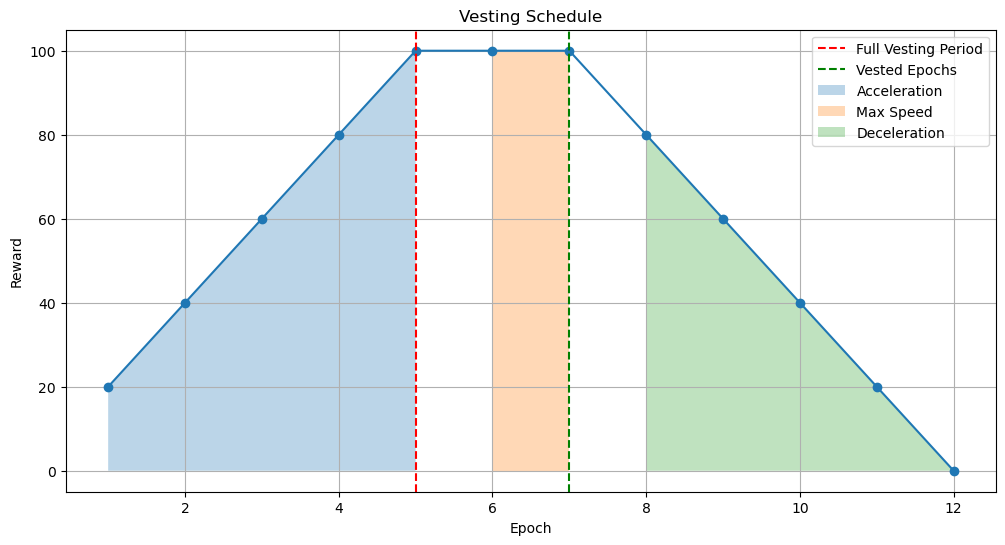

In [54]:
import matplotlib.pyplot as plt

def calc_additional_vesting(full_vesting_period, vested_epochs, reward_per_epoch):
	acceleration_epochs = min(full_vesting_period, vested_epochs)
	max_speed_epochs = max(0, vested_epochs - acceleration_epochs)
	reward_per_part = reward_per_epoch / full_vesting_period

	acceleration_parts = acceleration_epochs * (acceleration_epochs + 1) // 2
	max_speed_parts = max_speed_epochs * full_vesting_period

	unlocked_rewards = (acceleration_parts + max_speed_parts) * reward_per_part

	deceleration = []
	for i in range(full_vesting_period):
		if acceleration_epochs + i >= full_vesting_period and acceleration_epochs > 0:
			acceleration_epochs -= 1
		deceleration.append(acceleration_epochs * reward_per_part)

	return unlocked_rewards, deceleration

def visualize_vesting(full_vesting_period, vested_epochs, reward_per_epoch):
	unlocked_rewards, deceleration = calc_additional_vesting(full_vesting_period, vested_epochs, reward_per_epoch)

	print(f"Unlocked Rewards: {unlocked_rewards}")
	print(f"Deceleration: {deceleration}")

	# Calculate rewards per epoch
	rewards_per_epoch = []
	for epoch in range(1, vested_epochs + len(deceleration) + 1):
		if epoch <= full_vesting_period:
			reward = min(epoch, full_vesting_period) * (reward_per_epoch / full_vesting_period)
		elif epoch <= vested_epochs:
			reward = reward_per_epoch
		else:
			reward = deceleration[epoch - vested_epochs - 1]
		rewards_per_epoch.append(reward)

	# Visualize the vesting schedule
	plt.figure(figsize=(12, 6))
	plt.plot(range(1, len(rewards_per_epoch) + 1), rewards_per_epoch, marker='o')
	plt.axvline(x=full_vesting_period, color='r', linestyle='--', label='Full Vesting Period')
	plt.axvline(x=vested_epochs, color='g', linestyle='--', label='Vested Epochs')
	plt.fill_between(range(1, full_vesting_period + 1), rewards_per_epoch[:full_vesting_period], alpha=0.3, label='Acceleration')
	plt.fill_between(range(full_vesting_period + 1, vested_epochs + 1), rewards_per_epoch[full_vesting_period:vested_epochs], alpha=0.3, label='Max Speed')
	plt.fill_between(range(vested_epochs + 1, len(rewards_per_epoch) + 1), rewards_per_epoch[vested_epochs:], alpha=0.3, label='Deceleration')
	plt.xlabel('Epoch')
	plt.ylabel('Reward')
	plt.title('Vesting Schedule')
	plt.legend()
	plt.grid(True)
	plt.show()

# Example usage
full_vesting_period = 5
vested_epochs = 7
reward_per_epoch = 100

visualize_vesting(full_vesting_period, vested_epochs, reward_per_epoch)

In [ ]:
{1: [2, 5], 2: [10, 12], 3: [15, 18]}

### Tests

In [113]:
# vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch

def run_test_cases(calculate_vesting_func):
	test_cases = [
		# Basic cases
		(5, 10, 5, 50, 10, 44, "Simple case"),
		(5, 10, 5, 50, 10, 15, "Beginning of vesting"),
		(5, 10, 5, 50, 10, 35, "Middle of vesting"),
		(5, 10, 5, 50, 10, 60, "After CC ends periods"),
		(5, 10, 5, 50, 10, 1000, "After all vesting periods"),
		(5, 10, 5, 50, 10, 10, "On the vesting_period_duration * N epoch"),
		(5, 10, 12, 48, 10, 25, "Simple case 2"),
		
		# Edge cases with start and end epochs
		(5, 10, 7, 50, 10, 44, "Start epoch not multiple to duration"),
		(5, 10, 0, 50, 10, 25, "Start at epoch 0"),
		(5, 10, 12, 48, 10, 10, "Current epoch before start"),
		
		# Cases with different durations
		(5, 7, 5, 50, 10, 33, "Non-standard duration"),
		(5, 15, 5, 50, 10, 44, "Longer duration"),
		
		# Edge cases with duration multiples
		(5, 10, 5, 50, 10, 10, "At first vesting period end"),
		(5, 10, 5, 50, 10, 20, "At second vesting period end"),
		(5, 10, 5, 50, 10, 50, "At last vesting period end"),

	]

	for case in test_cases:
		vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch, description = case
		result = calculate_vesting_func(vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch)
		
		print(f"Test: {description}")
		print(f"Input:\nvesting_period_count={vesting_period_count},\nvesting_period_duration={vesting_period_duration},\n"
			  f"start_epoch_of_cc={start_epoch_of_cc},\nend_epoch_of_cc={end_epoch_of_cc},\n"
			  f"reward_per_epoch={reward_per_epoch},\n\ncurrent_epoch={current_epoch}\n")
		print(f"Total earned: {result['total_earned']}")
		print(f"Unlocked (ready to withdraw): {result['unlocked']}")
		print(f"In vesting: {result['in_vesting']}")
		print("-------")

# Run the tests
run_test_cases(calculate_vesting)

Test: Simple case
Input:
vesting_period_count=5,
vesting_period_duration=10,
start_epoch_of_cc=5,
end_epoch_of_cc=50,
reward_per_epoch=10,

current_epoch=44

Total earned: 390
Unlocked (ready to withdraw): 160.0
In vesting: 230.0
-------
Test: Beginning of vesting
Input:
vesting_period_count=5,
vesting_period_duration=10,
start_epoch_of_cc=5,
end_epoch_of_cc=50,
reward_per_epoch=10,

current_epoch=15

Total earned: 100
Unlocked (ready to withdraw): 10.0
In vesting: 90.0
-------
Test: Middle of vesting
Input:
vesting_period_count=5,
vesting_period_duration=10,
start_epoch_of_cc=5,
end_epoch_of_cc=50,
reward_per_epoch=10,

current_epoch=35

Total earned: 300
Unlocked (ready to withdraw): 90.0
In vesting: 210.0
-------
Test: After CC ends periods
Input:
vesting_period_count=5,
vesting_period_duration=10,
start_epoch_of_cc=5,
end_epoch_of_cc=50,
reward_per_epoch=10,

current_epoch=60

Total earned: 450
Unlocked (ready to withdraw): 330.0
In vesting: 120.0
-------
Test: After all vesting pe

## Visualisation (WIP)

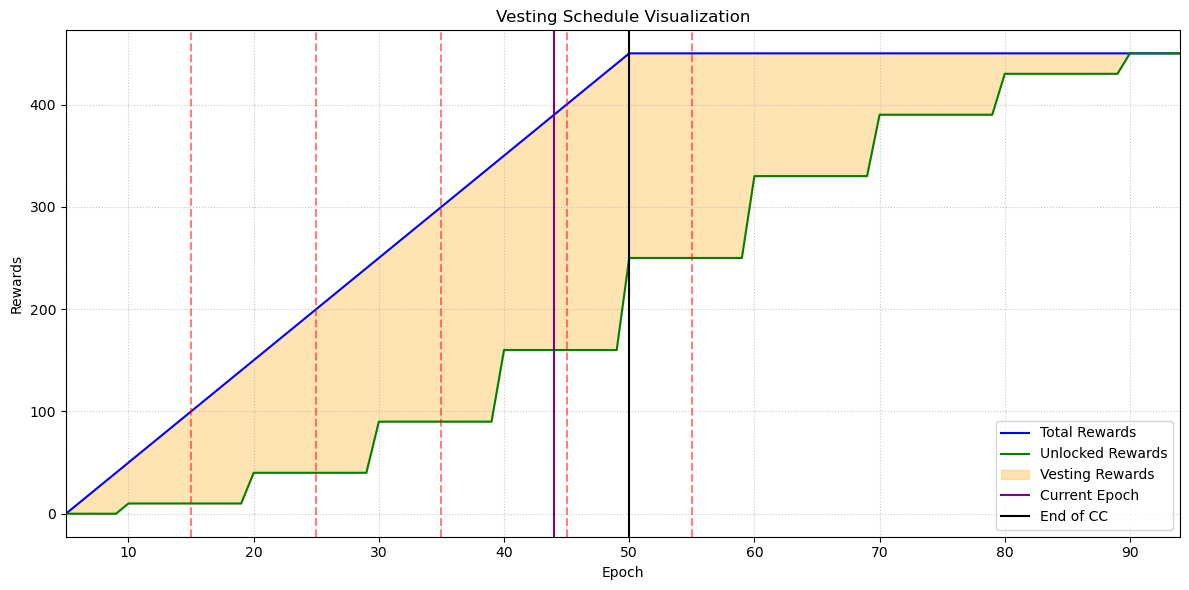

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_vesting(vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch):
	# Calculate vesting data
	result = calculate_vesting(vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, current_epoch)
	
	# Calculate the epoch when all rewards are unlocked
	total_vesting_duration = vesting_period_count * vesting_period_duration
	last_reward_epoch = min(end_epoch_of_cc, current_epoch)
	all_unlocked_epoch = min(last_reward_epoch + total_vesting_duration, end_epoch_of_cc + total_vesting_duration)
	
	# Create epoch range for x-axis
	epochs = np.arange(start_epoch_of_cc, all_unlocked_epoch + 1)
	
	# Calculate cumulative rewards
	cumulative_rewards = np.minimum(np.maximum(epochs - start_epoch_of_cc, 0), end_epoch_of_cc - start_epoch_of_cc) * reward_per_epoch
	
	# Calculate unlocked rewards for each epoch
	unlocked_rewards = np.array([calculate_vesting(vesting_period_count, vesting_period_duration, start_epoch_of_cc, end_epoch_of_cc, reward_per_epoch, epoch)['unlocked'] for epoch in epochs])
	
	# Create the plot
	fig, ax = plt.subplots(figsize=(12, 6))
	
	# Plot total rewards
	ax.plot(epochs, cumulative_rewards, label='Total Rewards', color='blue')
	
	# Plot unlocked rewards
	ax.plot(epochs, unlocked_rewards, label='Unlocked Rewards', color='green')
	
	# Fill the area between total and unlocked rewards (vesting rewards)
	ax.fill_between(epochs, unlocked_rewards, cumulative_rewards, alpha=0.3, label='Vesting Rewards', color='orange')
	
	# Add vertical lines for vesting period boundaries
	for period in range(vesting_period_count + 1):
		epoch = start_epoch_of_cc + period * vesting_period_duration
		if epoch <= all_unlocked_epoch:
			ax.axvline(x=epoch, color='red', linestyle='--', alpha=0.5)
	
	# Add vertical line for current epoch
	ax.axvline(x=current_epoch, color='purple', linestyle='-', label='Current Epoch')
	
	# Add vertical line for end of CC
	ax.axvline(x=end_epoch_of_cc, color='black', linestyle='-', label='End of CC')
	
	# Set labels and title
	ax.set_xlabel('Epoch')
	ax.set_ylabel('Rewards')
	ax.set_title('Vesting Schedule Visualization')
	ax.legend()
	
	# Show grid
	ax.grid(True, linestyle=':', alpha=0.7)
	
	# Set x-axis limits
	ax.set_xlim(start_epoch_of_cc, all_unlocked_epoch)
	
	# Show the plot
	plt.tight_layout()
	plt.show()

# Example usage
visualize_vesting(
	vesting_period_count=5,
	vesting_period_duration=10,
	start_epoch_of_cc=5,
	end_epoch_of_cc=50,
	reward_per_epoch=10,
	current_epoch=44
)